In [1]:
import os
import random
import math
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf

# for tokenizing
nltk.download('punkt')

# for POS tagging
from nltk.tag.perceptron import AveragedPerceptron
from nltk.tag.perceptron import PerceptronTagger


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Prepare Web Corpus

In [2]:
class PrepareDataWeb():
    def __init__(self):
        self.categories = ["/businessEconomy", "/lifestyle", "/politics", "/technology"] 
        self.tokenized_sentences = []
        self.word_freq_dict = dict()
        self.category_sent_dict = dict()

    def load(self, write_to_file=True):
        """Retun a list of tokenized sentences and a word frequency dictionary"""
        cwd = os.getcwd()

        for category in self.categories:
            docs_list = os.listdir(cwd+category)
            for docs in docs_list:
                doc_path = cwd+category+"/"+docs
                tkn_sent, tkn_dict = self._load_data(doc_path)
                self.tokenized_sentences += tkn_sent
                self.word_freq_dict = self._merge_dict(self.word_freq_dict, tkn_dict)
                if category not in self.category_sent_dict:
                    self.category_sent_dict[category] = tkn_sent
                else:
                    self.category_sent_dict[category] += tkn_sent

        if write_to_file:
            f = open("category_sent.txt", "w")
            for cat in self.category_sent_dict:
                f.write(f"CATEGORY\t: {cat}\n")
                for sentence in self.category_sent_dict[cat]:
                    f.write(self._to_sent(sentence) + "\n")
                f.write("\n\n")
            
            f.close()

        return self.tokenized_sentences, self.word_freq_dict

    def analysze_category(self):
        """
        for each category, get the :
            - number of sentences
            - average word count
            (for tagged version, do the total number of tokens)
        """
        for category in self.category_sent_dict:
            print(f"Category: {category}")
            num_sentences = len(self.category_sent_dict[category])
            print(f"number of sentences: {num_sentences}")
            # word_count = lambda sentence: len(nltk.word_tokenize(sentence))
            wc = 0
            for sentence in self.category_sent_dict[category]:
                wc += len(sentence)
            print(f"average word count: {math.floor(wc/num_sentences)}\n")


    def get_statistics(self):
        """Return a general report of the corpus statistics
            Statistics to return:
            - total number of sentences
            - average word count in a sentence
            - max sentence length
            - min sentence length
        """
        total_wc = 0
        word_count = lambda sentence: len(sentence)
        freq_dict = dict() # key: word count, value: num of sentences with that word count
        for sentences in self.tokenized_sentences:
            wc = word_count(sentences)
            total_wc += wc
            if wc not in freq_dict:
                freq_dict[wc] = 1
            else:
                freq_dict[wc] += 1
        print("TOTAL WC IS ", total_wc)
        
        average_wc = math.floor(total_wc / len(self.tokenized_sentences))
        # the shortest sentence by word count
        min_sent = min(self.tokenized_sentences, key=word_count)
        # the longest sentence by word count
        max_sent = max(self.tokenized_sentences, key=word_count)
        min_wc = word_count(min_sent)
        max_wc = word_count(max_sent)

        print("CORPUS STATISTICS")
        print(f"There are a total of {len(self.tokenized_sentences)} sentences in the corpus from Web\n")
        print(f"\tAverage word count\t:\t{average_wc}\n")
        print(f"\tmaximum sentence length\t:\t{max_wc}\n")
        print(f"\tsentence:\n")
        print(f"\t{self._to_sent(max_sent)}\n")
        print(f"\tminimum sentence length\t:\t{min_wc}\n")
        print(f"\tsentence:\n")
        print(f"\t{self._to_sent(min_sent)}\n")


        plt.figure(figsize=(10, 7.5))
        plt.title("word count per sentences distribution")
        plt.ylabel("sentences with word count")
        plt.xlabel("word count")
        plt.bar(x=freq_dict.keys(), height=freq_dict.values())

    def _load_data(self, path):
        """Return a list of tokenized sentence from a document in path, and
        a dictionary of frequency of word

        Args:
            path: the path of the file (in txt) to parse and tokenize
        """
        f = open(path, "r")
        text = f.read()
        token_dict = dict()

        # documents -> list of sentences
        sentences_lst = nltk.sent_tokenize(text)

        # list of sentences -> list of tokenized sentences
        tokenized_sentences = []
        for sentence in sentences_lst:
            tokenized = nltk.word_tokenize(sentence)
            tokenized_sentences.append(tokenized)
            for token in tokenized:
                if token in token_dict:
                    token_dict[token] += 1
                else:
                    token_dict[token] = 1

        f.close()
        return tokenized_sentences, token_dict

    def _merge_dict(self, dict1, dict2):
        """Return a new dictionary with the content of dict1 and dict2"""  
        res = {**dict1, **dict2}
        return res

    def _to_sent(self, tokenized_sent):
        sent = ""
        for token in tokenized_sent:
            sent += token + " "
        return sent.strip()

In [3]:
web_data = PrepareDataWeb()
tokenized_sentences, word_freq_dict = web_data.load()

In [4]:
web_data.analysze_category()

Category: /businessEconomy
number of sentences: 261
average word count: 21

Category: /lifestyle
number of sentences: 262
average word count: 16

Category: /politics
number of sentences: 196
average word count: 21

Category: /technology
number of sentences: 236
average word count: 21



In [13]:
tokenized_sentences[0]

['Kementerian',
 'PUPR',
 'fokus',
 'pada',
 'lima',
 'program',
 'prioritas',
 'nasional',
 'selama',
 'pandemi',
 'dalam',
 'rangka',
 'mendukung',
 'pemulihan',
 'ekonomi',
 'nasional',
 '(',
 'PEN',
 ')',
 '.']

TOTAL WC IS  19150
CORPUS STATISTICS
There are a total of 955 sentences in the corpus from Web

	Average word count	:	20

	maximum sentence length	:	77

	sentence:

	Lalu ada pula Pondok Indah ( Pondok Indah Town House dan Perumahan Pondok Indah ) , Pantai Indah Kapuk ( Bukit Gold Mediterania , Komplek Johar , dan Golf Coast PIK ) , Bumi Serpong Damai ( Boulevard BSD , Puspita Loka CLuster , dan Provence Parland ) , Widya Chandra ( Komplek Widya Chandra dan Perumahan Dinas Menteri Widya Chandra ) , dan Alam Sutera ( Kunciran Mas , Griya Sutera dan Sutera Lavender ) .

	minimum sentence length	:	2

	sentence:

	390 .



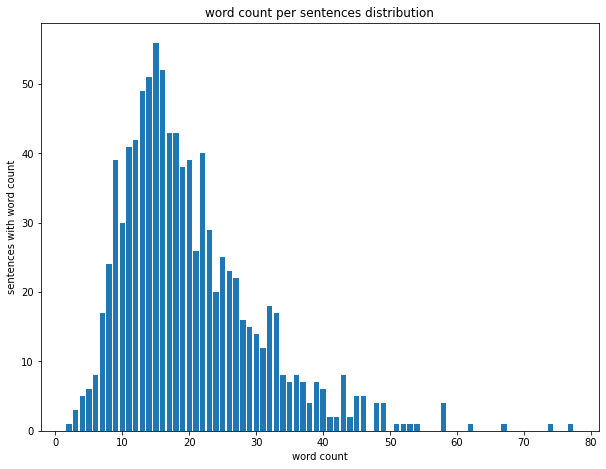

In [6]:
web_data.get_statistics()

# Prepare Tagged Corpus

In [5]:
tagged_path = tf.keras.utils.get_file(fname="tagged_tsv_gh", origin="https://raw.githubusercontent.com/famrashel/idn-tagged-corpus/master/Indonesian_Manually_Tagged_Corpus_ID.tsv")

2768896/2764611 [==============================] - 0s 0us/step


In [6]:
class PrepareData():
    def __init__(self, path):
        self.tagged_data = path
        self.pos_tags = dict()
        self.data = []
        self.pos_tags_set = set()

    def load(self):
        f = open(self.tagged_data, "r")
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line[:2] == "</":
                # end of a sentence
                self.data.append(tagged_entry)
            elif line[:1] == "<":
                # instantiate a new tagged entry
                tagged_entry = []
            else:
                lst = line.split("\t")
                word = lst[0]
                tag = lst[1]

                # add entry to tagged_entry to build tagged sentence
                entry = (word, tag)
                tagged_entry.append(entry)
                
                # add the tag and word to pos_tags
                if tag not in self.pos_tags:
                    self.pos_tags[tag] = set(word)
                else:
                    self.pos_tags[tag].add(word)

        self.pos_tags_set = set(self.pos_tags.keys())

    def split_test_train(self, ratio=0.8):
        """Split the data into test set and train set. Default ratio is 80% train and 20% test"""
        num_train_data = len(self.data)
        choose = math.floor(num_train_data * (1 - ratio))
        test_data = random.sample(self.data, choose)
        train_data = list(filter(lambda i: i not in test_data, self.data))
        return train_data, test_data

    def get_modal_frequency(self):
        """Return the number of words / token per modal type"""
        modal_freq = dict()
        for modal in self.pos_tags_set:
            modal_freq[modal] = len(self.pos_tags[modal])
        return modal_freq

    def get_words(self, modal, length="all", as_string=False):
        """Return a list of words that are in modal category. default length is all
        """
        ret = []
        if modal in self.pos_tags_set:
            ret = list(self.pos_tags[modal])
        else:
            print(f"{modal} is not recognized")
        if length != "all":
            ret = ret[:length]
        if as_string:
            ret = ", ".join(ret)
            ret = ret.strip()
        return ret
    
    def get_statistics(self):
        """Return a general report of the corpus statistics
            Statistics to return:
            - total number of sentences
            - average word count in a sentence
            - max sentence length
            - min sentence length
        """
        sent_list = []
        total_wc = 0
        freq_dict = dict() # key: word count, value: num of sentences with that word count
        word_count = lambda sentence: len(nltk.word_tokenize(sentence))
        
        for tagged_sent in self.data:
            sent = to_sent(tagged_sent)
            sent_list.append(sent)
            total_wc += word_count(sent)
            if word_count(sent) in freq_dict:
                freq_dict[word_count(sent)] += 1
            else:
                freq_dict[word_count(sent)] = 1
        
        min_sent = min(sent_list, key=word_count) # the shortest sentence by word count
        max_sent = max(sent_list, key=word_count) # the longest sentence by word count
        min_wc = word_count(min_sent)
        max_wc = word_count(max_sent)
        average_wc = math.floor(total_wc / len(sent_list))
        print("CORPUS STATISTICS")
        print(f"There are a total of {len(sent_list)} sentences in the corpus from {self.tagged_data}\n")
        print(f"\tAverage word count\t:\t{average_wc}\n")
        print(f"\tmaximum sentence length\t:\t{max_wc}\n")
        print(f"\tsentence:\n")
        print(f"\t{max_sent}\n")
        print(f"\tminimum sentence length\t:\t{min_wc}\n")
        print(f"\tsentence:\n")
        print(f"\t{min_sent}\n")

        plt.figure(figsize=(10, 7.5))
        plt.title("word count per sentences distribution")
        plt.ylabel("sentences with word count")
        plt.xlabel("word count")
        plt.bar(freq_dict.keys(), freq_dict.values(), width=0.75)

In [7]:
def to_sent(tagged_sent):
    """Return a sentence from a tagged sentence version"""
    sent = ""
    for (word, tag) in tagged_sent:
        sent += word + " "
    return sent.strip()

def get_tag(tagged_sent, word_to_tag):
    """Retrieve the POS tag of a word in a tagged sentence"""
    for (word, tag) in tagged_sent:
        if word_to_tag == word:
            return tag
    return f"{word_to_tag} is not in the sentence"

In [53]:
tagged_data = PrepareData(tagged_path)
tagged_data.load()
train_data, test_data = tagged_data.split_test_train(ratio=0.9)
data = tagged_data.data

In [9]:
tagged_data.get_modal_frequency()

{'CC': 52,
 'CD': 2892,
 'DT': 9,
 'FW': 838,
 'IN': 101,
 'JJ': 771,
 'MD': 42,
 'NEG': 16,
 'NN': 5419,
 'NND': 90,
 'NNP': 5613,
 'OD': 41,
 'PR': 29,
 'PRP': 30,
 'RB': 193,
 'RP': 11,
 'SC': 138,
 'SYM': 33,
 'UH': 12,
 'VB': 2922,
 'WH': 24,
 'X': 248,
 'Z': 15,
 'fw': 4}

In [12]:
# tagged_data.get_words("fw", length=7, as_string=True)

'e, s, a, l'

In [9]:
print(to_sent(train_data[15]))
print(get_tag(train_data[15], "sudah"))

Kedua orang terkaya dunia itu sudah berhasil membujuk banyak orang yang sangat kaya di Amerika agar menyumbangkan separuh kekayaan mereka .
MD


CORPUS STATISTICS
There are a total of 10030 sentences in the corpus from /root/.keras/datasets/tagged_tsv_gh

	Average word count	:	26

	maximum sentence length	:	83

	sentence:

	Dikatakan -nya , inflasi terjadi karena adanya kenaikan harga yang ditunjukkan oleh kenaikan indeks pada kelompok barang dan jasa , yaitu kelompok bahan makanan 1,87 persen , kelompok makanan jadi , minuman , rokok & tembakau 0,51 persen , kelompok perumahan , air , listrik , gas & bahan bakar 0,21 persen , kelompok sandang 2,05 persen , kelompok kesehatan 0,45 persen , kelompok pendidikan , rekreasi dan olahraga 0,21 persen , dan kelompok transpor , komunikasi & jasa keuangan 0,47 persen .

	minimum sentence length	:	2

	sentence:

	Calon selebriti



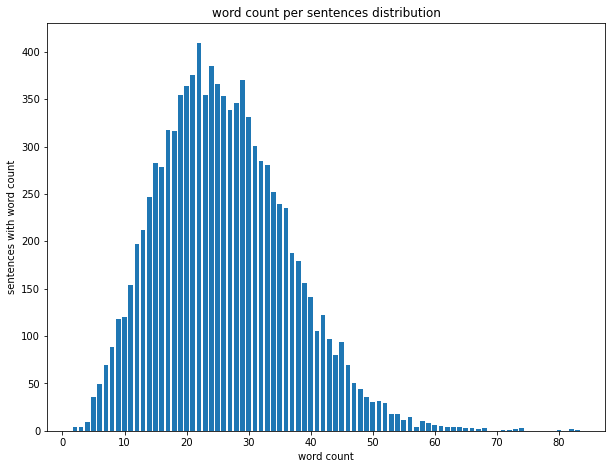

In [10]:
prepare_data.get_statistics()

# Modal Analysis

In [10]:
default_modal = set(["akan", "ingin", "mau", "telah", "sudah", "pernah", "masih", "bisa", "dapat", "boleh", "ikut", "harus", "suka", "senang"])

In [11]:
def get_modal(data, default_modal):
    """Return the sentences that contains auxiliary verb from the prepared data
        and the set of modal / auxiliary words

        Args:
            train_data: from the corpus of tagged words
            default_modal: a set of default modal words that will be used 
                to detect possible modal that is not labeled as modal

        Return data will be a dictionary:
            key: modal words
            values: list of sentences containing the modal words (no repeat)
    """
    f = open("report.txt", "w")
    modal_sent_dict = dict()
    num_misclassified_modal = 0
    for sentence in data:
        for entry in sentence:
            word = entry[0]
            tag = entry[1]
            if tag == "MD":
                if word not in modal_sent_dict:
                    modal_sent_dict[word] = [sentence]
                elif sentence not in modal_sent_dict[word]:
                    modal_sent_dict[word].append([sentence])    
            elif word in default_modal:
                f.write(f"the word {word} is a modal but not tagged as MD\n")
                f.write(f"\t{word} is classified as {tag}\n")
                f.write(f"\tin sentence {sentence}\n")
                f.write("\n")
                num_misclassified_modal += 1
    f.close()
    print(f"there are {num_misclassified_modal} instances where modal words that are not classified as modal")
    print(f"there are {len(modal_sent_dict.keys())} modal words")
    print(f"{modal_sent_dict.keys()}")
    # for each modal words in the key set, make the value to a set then back to list
    

In [12]:
get_modal(data, default_modal)

there are 131 instances where modal words that are not classified as modal
there are 39 modal words
dict_keys(['akan', 'bisa', 'harus', 'telah', 'sudah', 'baru', 'mulai', 'pernah', 'masih', 'sempat', 'sedang', 'tengah', 'mau', 'sepertinya', 'perlu', 'boleh', 'dapat', 'mungkin', 'bakal', 'kemungkinan', 'sedikit', 'Baru', 'Bisa', 'hendak', 'Mungkin', 'Sudah', 'barangkali', 'Harus', 'Pernah', 'Masih', 'Akan', 'guna', 'Dapat', 'usah', 'mesti', 'kan', 'Telah', 'lagi', 'Perlu'])


In [57]:
perceptron_tagger = PerceptronTagger(load=False)

In [58]:
# RUN THIS IF YOU WANT TO RETRAIN
perceptron_tagger.train(train_data, save_loc="trained_model_split_90.pickle")

In [34]:
# LOAD THE SAVED MODEL
perceptron_tagger.load("trained_model_split_80.pickle")

In [60]:
def calculate_accuracy(model, test_data):
    correctly_predicted_tags = 0
    total_tags = 0
    num_sent_misclassified = 0
    for sentence in test_data:
        # each sentence is a [(word, tag) pair]
        tokenized_sent = [word for word, tag in sentence]
        correct_tags = [tag for word, tag in sentence]
        predicted = model.tag(tokenized_sent)
        predicted_tags = [tag for word, tag in predicted]
        total_tags += len(predicted_tags)
        if predicted_tags != correct_tags:
            num_sent_misclassified += 1
        for i in range(len(predicted_tags)):
            if predicted_tags[i] == correct_tags[i]:
                correctly_predicted_tags += 1
                # print(f"correct tags is {correct_tags[i]}, but predicted as {predicted_tags[i]}")
    
    accuracy = round(correctly_predicted_tags / total_tags, 2)
    print(accuracy)
    print(num_sent_misclassified)
    
    # print(correctly_predicted_tags)
    # print(total_tags)

In [52]:
# calculate accuracy based on 80% data split
calculate_accuracy(perceptron_tagger, test_data)

0.97


In [61]:
# calculate accuracy based on 90% data split
calculate_accuracy(perceptron_tagger, test_data)


0.97
472


In [ ]:
# calculate accuracy per pos tags 

In [19]:
def tag_web_data(tokenized_sentences):
    tagged_sentences = []
    for tokenized_sent in tokenized_sentences:
        tagged_sent = perceptron_tagger.tag(tokenized_sent)
        tagged_sentences.append(tagged_sent)

    return tagged_sentences

In [21]:
print(len(tokenized_sentences))
tagged_sentences = tag_web_data(tokenized_sentences)
print(len(tagged_sentences))
print(tagged_sentences[1])

955
955
[('Salah', 'JJ'), ('satunya', 'RB'), ('dengan', 'IN'), ('program', 'NN'), ('padat', 'NN'), ('karya', 'NN'), ('tunai', 'JJ'), ('yang', 'SC'), ('saat', 'NN'), ('ini', 'PR'), ('realisasinya', 'MD'), ('mencapai', 'VB'), ('40', 'CD'), ('%', 'SYM'), ('dan', 'CC'), ('diperkirakan', 'VB'), ('menyerap', 'VB'), ('1,2', 'CD'), ('juta', 'CD'), ('tenaga', 'NN'), ('kerja', 'NN'), ('.', 'Z')]


In [ ]:
def detect_auxiliary(tokenized_sentences):
    """Detect auxiliary verbs or modal verbs'""